# Alex Deleon MATH328

In this analysis we will attempt to predict whether or not a patient will have a stroke based on a number of characteristics. This dataset is interesting to me because two of my family members had strokes in my youth. Other family members almost had one. Because of this I seeking to know from a statistical perspective, what are some predictors of strokes?

I found this dataset on kaggle https://www.kaggle.com/fedesoriano/stroke-prediction-dataset. The data source is "confidential". This dataset contains information on patients who had (or did not have) a stroke. Patient information includes gender, body mass index, average glucose level, residence type, if the patient is a smoker, and so on.

#### What is the structure or shape of the data?

The stroke dataset is rectangular and in csv format. There is a mixture of quantitative and qualitiative dataset.

Quantitative columns: age (discrete), average glucose level (continuous), and body mass index (continuous).
Qualitative columns: gender (nominal), presence of hypertension (binary), presence of heart disease (binary), marriage status (binary), type of work (nominal), type of residence (nominal), smoker status (binary), recorded stroke (binary)

#### What is the granularity of the data?

Each row represents a patient, i.e., a person. 

####  What is the scope or completeness of the data?

The data satisfies our question(s) of interest. We can identify the variables that best explain or predict a stoke.

#### What is the temporality of the data, or how does the data relate to time?

It does not specify when the data was collected.

#### What is the faithfulness of the data, or how well does the data capture reality?

The data seems legitamate at first sight. What is troublesome is the lack of documentation and methodology provided for the dataset. How exactly was this dataset collected and by who? This question is vital.


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.ticker as mtick
%matplotlib inline

pd.set_option('display.max_columns', None)

In [2]:
from pathlib import Path
import os

BASE_DIR = Path(os.path.abspath('')).resolve()
STROKE_PATH= BASE_DIR.joinpath('STROKE_DATA.csv')
stroke_df=pd.read_csv(STROKE_PATH)

# Missing Values

### We see that there are some missing values in the column bmi and smoking_status. For some patients, smoking status is "Unknown". Let's treat these .

In [3]:
stroke_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


### Let's check if we should impute "Unknown" smoking status values as "No" for children. We see that children are defined as any patient under the age of 16.

In [4]:
max_age=stroke_df.loc[stroke_df['work_type']=='children','age'].max()
print ("The max age for a patient to be considered a child in this dataset is",max_age)

The max age for a patient to be considered a child in this dataset is 16.0


### There may be some mistakes where work type for children under 14 is something other than "children". Under the Fair Labor Standards Act ([FLSA](https://www.dol.gov/agencies/whd/flsa)), the minimum age for employment is 14. Let's verify that the work type of patients under 14 is "children". There are 15 patients under 14 with a  work type that is not "children". Let substitue these values.

In [5]:
def child_work(row):
    if (row['age']<14 and row['work_type']!='children'):
        row['work_type']='children'
    return row

stroke_df.loc[(stroke_df['age']<14),'work_type'].value_counts()

children         630
Private           10
Never_worked       3
Self-employed      2
Name: work_type, dtype: int64

### Non-children values have been changed to "children".

In [6]:
stroke_df = stroke_df.apply(child_work,axis=1) 
stroke_df.loc[(stroke_df['age']<14),'work_type'].value_counts()

children    645
Name: work_type, dtype: int64

### The assumption can be made that all children in this dataset are non-smokers. However, this depends on how smoking is defined. If this dataset considers children who experience secondhand smoke as patients who smoke, then this assumption would be wrong. From the cross tab below, we see that it is possible that this dataset considers secondhand smoke. There are 15 children who have either smoked or formely smoked.

In [7]:
pd.crosstab(stroke_df.work_type,stroke_df.smoking_status)

smoking_status,Unknown,formerly smoked,never smoked,smokes
work_type,,,,
Govt_job,122,133,282,120
Never_worked,6,0,13,0
Private,636,531,1206,542
Self-employed,155,207,331,124
children,625,14,60,3


### We will drop all rows that have smoker labeled as "Unknown"

In [8]:
stroke_df['smoking_status'] = stroke_df['smoking_status'].replace('Unknown', np.nan)
stroke_df=stroke_df.dropna()
stroke_df['smoking_status'].value_counts()

never smoked       1852
formerly smoked     837
smokes              737
Name: smoking_status, dtype: int64

### We will drop the row where gender is labeled as "Other"

In [9]:
stroke_df['gender'].value_counts()

Female    2086
Male      1339
Other        1
Name: gender, dtype: int64

In [10]:
stroke_df['gender'] = stroke_df['gender'].replace('Other', np.nan)
stroke_df=stroke_df.dropna()
stroke_df['gender'].value_counts()

Female    2086
Male      1339
Name: gender, dtype: int64

### We see that after removing the 'unknown' smoker rows, there are no longer any null values in the column bmi

In [11]:
stroke_percent=stroke_df['stroke'].value_counts()/stroke_df['stroke'].shape[0]
stroke_percent.to_list()

[0.9474452554744526, 0.052554744525547446]

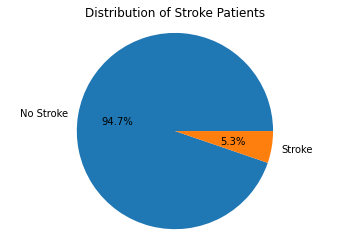

In [12]:
import seaborn as sns

plt.pie(stroke_percent.to_list(),labels=['No Stroke','Stroke'],autopct='%1.1f%%')
plt.title('Distribution of Stroke Patients')
plt.axis('equal')
plt.show()

In [13]:
stroke_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5100,68398,Male,82.0,1,0,Yes,Self-employed,Rural,71.97,28.3,never smoked,0
5102,45010,Female,57.0,0,0,Yes,Private,Rural,77.93,21.7,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0


In [14]:
str_only = stroke_df[stroke_df['stroke'] == 1]
no_str_only = stroke_df[stroke_df['stroke'] == 0]
ticks= {'gender':['Female','Male'],
        'ever_married':['Married','Not Married'],
        'heart_disease':['Heart\nDisease','No Heart\nDisease'],
        'hypertension':['No History','History'],
        'Residence_type':['Urban','Rural'],
        'smoking_status':['Never \n Smoker','Previous \n Smoker','Smoker'],
        'work_type':['Private','Self-Employed','Govt. \n Employee','Child','Never Worked']
       }

xlabels={'gender':'Gender',
         'ever_married':'Marriage Status',
         'heart_disease':'Heart Disease',
         'hypertension':'Hypertension',
         'Residence_type':'Residence Type',
         'smoking_status':'Smoking Status',
         'work_type':'Work Type'}


stroke
         gender  Percentage
Female     105   58.333333
Male        75   41.666667

nostroke
         gender  Percentage
Female    1981   61.047766
Male      1264   38.952234

stroke
      ever_married  Percentage
Yes           160   88.888889
No             20   11.111111

nostroke
      ever_married  Percentage
Yes          2439   75.161787
No            806   24.838213

stroke
    heart_disease  Percentage
0            144        80.0
1             36        20.0

nostroke
    heart_disease  Percentage
0           3075   94.761171
1            170    5.238829

stroke
    hypertension  Percentage
0           123   68.333333
1            57   31.666667

nostroke
    hypertension  Percentage
0          2894   89.183359
1           351   10.816641

stroke
        Residence_type  Percentage
Urban              94   52.222222
Rural              86   47.777778

nostroke
        Residence_type  Percentage
Urban            1651   50.878274
Rural            1594   49.121726

stroke
    

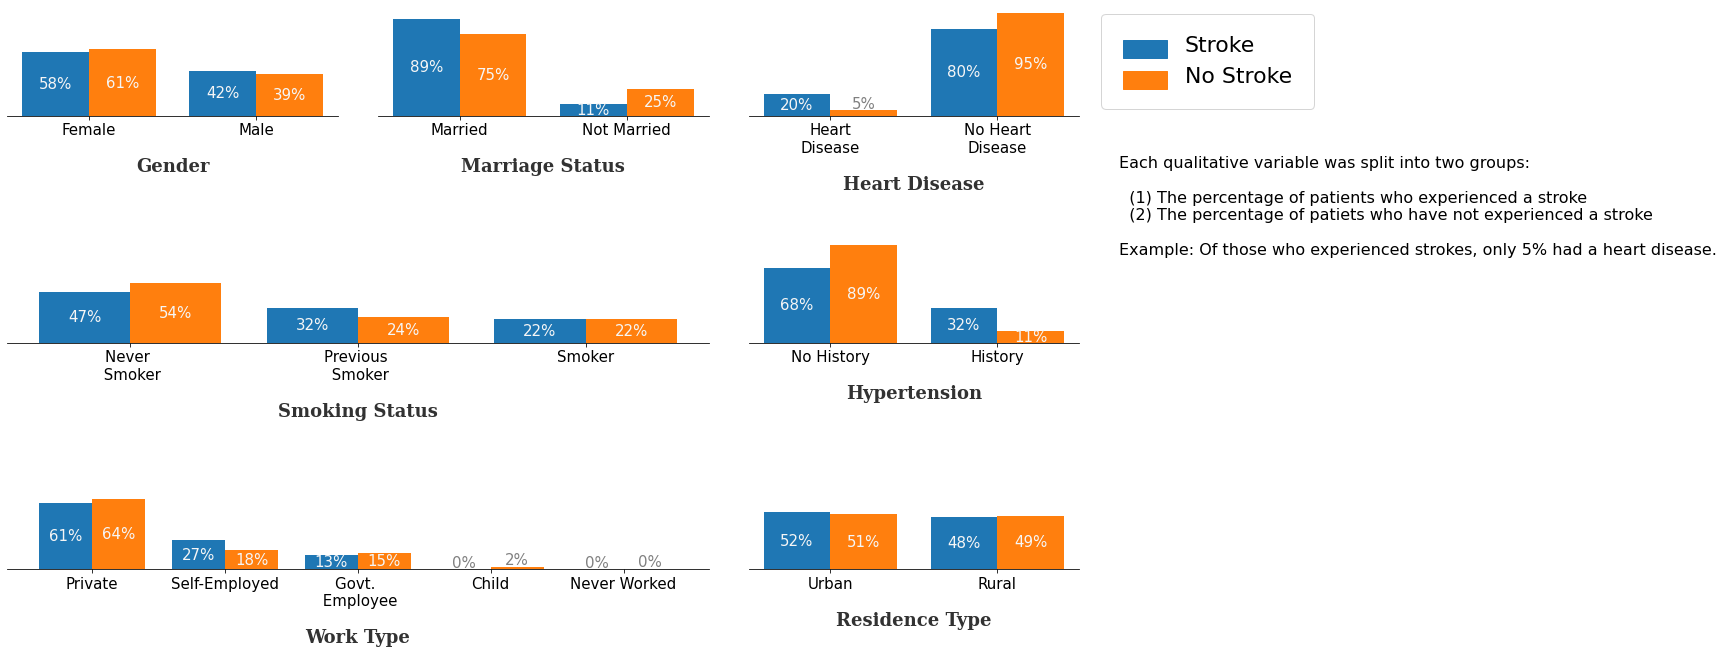

In [15]:
import matplotlib.gridspec as gridspec
fig3 = plt.figure(constrained_layout=False)

gs = fig3.add_gridspec(3,3)
ax1 = fig3.add_subplot(gs[0,0])
ax2 = fig3.add_subplot(gs[0,1])
ax3 = fig3.add_subplot(gs[0,2])
ax4 = fig3.add_subplot(gs[1,2])
ax5 = fig3.add_subplot(gs[1,:2])
ax6 = fig3.add_subplot(gs[2,2])
ax7 = fig3.add_subplot(gs[2,:2])

def getPercent_df(df,category):
    temp_df = pd.DataFrame(df[category].value_counts())
    temp_df["Percentage"] = temp_df[category].apply(lambda x:x/sum(temp_df[category])*100)
    return temp_df

def addBarChart(ax,category):
    hadStroke=getPercent_df(str_only,category)
    print('\nstroke\n',hadStroke)
    noStroke=getPercent_df(no_str_only,category)
    print('\nnostroke\n',noStroke)
    
    if 'work_type' in category:
        add_categories=pd.DataFrame({'work_type':[0,0],'Percentage':[0,0]},index=['Govt_job','children'])
        hadStroke=pd.concat([hadStroke,add_categories])
        
    if 'heart' in category:
        hadStroke=getPercent_df(str_only,category).sort_index(ascending=False)
        noStroke=getPercent_df(no_str_only,category).sort_index(ascending=False)
        
    x = np.arange(len(hadStroke))
    
    ax.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))

    ax.bar(x, height=hadStroke["Percentage"], zorder=3, color="tab:blue", width=0.4)
    ax.bar(x+0.4, height=noStroke["Percentage"], zorder=3, color="tab:orange", width=0.4)

    ax.set_xticks(x + 0.4 / 2)

    ax.set_xticklabels(hadStroke.index.tolist())

    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.yaxis.set_major_locator(mtick.MultipleLocator(10))
    ax.set_xticklabels(ticks[category], fontsize=15)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    #xlbl = ax.xaxis.get_label().get_text()
   # ax.set_xlabel(xlabels[xlbl],fontsize=19)
   # ax.xaxis.set_label_coords(0.5,4)
    
    ax.set_ylim([0,100])
    length=[i for i in range(0,len(hadStroke.index.tolist()))]
    for i,j in zip(length, hadStroke["Percentage"]):
        if j <=5.5:
            xy=(i, j+6)
            color='#808080'
        else:
            xy=(i, j/2)
            color='#f6f6f6'
        ax.annotate(f'{j:0.0f}%',
                    xy=xy, 
                    color=color, 
                    horizontalalignment='center', 
                    verticalalignment='center',
                    size = 15)
        
    for i,j in zip(length, noStroke["Percentage"]):
        if j <=5.5:
            xy=(i+0.4, j+6)
            color='#808080'
        else:
            xy=(i+0.4, j/2)
            color='#f6f6f6'
        ax.annotate(f'{j:0.0f}%',
                    xy=xy, 
                    color=color, 
                    horizontalalignment='center', 
                    verticalalignment='center',
                    size = 15)
        
    ax.set_xlabel( xlabels[category], fontsize=18, fontweight='bold', fontfamily='serif', color="#323232",labelpad=20)  
    
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='tab:orange', label='No Stroke')
blue_patch = mpatches.Patch(color='tab:blue', label='Stroke')
leg = fig3.legend(loc='upper left',
                 bbox_to_anchor=(.975, .95),
                 borderpad=1, prop={'size': 22},
                 handles=[blue_patch,red_patch],
                 ncol=1)

for patch in leg.get_patches():
    patch.set_height(18)
    patch.set_y(-6)
    
addBarChart(ax1,'gender')       
addBarChart(ax2,'ever_married')  
addBarChart(ax3,'heart_disease')  
addBarChart(ax4,'hypertension') 
addBarChart(ax6,'Residence_type') 
addBarChart(ax5,'smoking_status') 
addBarChart(ax7,'work_type')

#fig3.suptitle("Percentage of stroke patients by qualitiative variable",fontsize=26,x=0.5,y=.93)
fig3.text(1.00, .60,"""Each qualitative variable was split into two groups:\n\n  (1) The percentage of patients who experienced a stroke \n  (2) The percentage of patiets who have not experienced a stroke\n\nExample: Of those who experienced strokes, only 5% had a heart disease.""",fontsize=16)
fig3.set_size_inches(16,10)
fig3.tight_layout(pad=4.0)

# Encode Variables: For binary variables w

In [16]:
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [17]:
stroke_df.loc[:,'ever_married'].replace({'Yes':1,'No':0 },inplace=True)

work_types={'Private':2,'Self-employed':1,'Govt_job':3,'children':0,'Never_worked':0}
stroke_df.loc[:,'work_type'] .replace(work_types,inplace=True)

stroke_df.loc[:,'smoking_status'].replace({'smokes':2,'formerly smoked':3,'never smoked':1,'Unknown':0},inplace=True)

stroke_df=pd.concat([stroke_df,pd.get_dummies(stroke_df[['gender','Residence_type']])],axis=1).drop(columns=['Residence_type','gender'])

In [18]:
stroke_df

,id,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke,gender_Female,gender_Male,Residence_type_Rural,Residence_type_Urban
0,9046,67.0,0,1,1,2,228.69,36.6,3,1,0,1,0,1
2,31112,80.0,0,1,1,2,105.92,32.5,1,1,0,1,1,0
3,60182,49.0,0,0,1,2,171.23,34.4,2,1,1,0,0,1
4,1665,79.0,1,0,1,1,174.12,24.0,1,1,1,0,1,0
5,56669,81.0,0,0,1,2,186.21,29.0,3,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5100,68398,82.0,1,0,1,1,71.97,28.3,1,0,0,1,1,0
5102,45010,57.0,0,0,1,2,77.93,21.7,1,0,1,0,1,0
5106,44873,81.0,0,0,1,1,125.20,40.0,1,0,1,0,0,1
5107,19723,35.0,0,0,1,1,82.99,30.6,1,0,1,0,1,0


In [19]:
stroke_df['stroke'].value_counts()

0    3245
1     180
Name: stroke, dtype: int64

# Modeling

In [20]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.gridspec as grid_spec
import seaborn as sns
from imblearn.over_sampling import SMOTE


from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score

In [21]:
from imblearn.over_sampling import SMOTE
X  = stroke_df[[col for col in stroke_df.columns if col != 'stroke']]
y = stroke_df['stroke']

smote = SMOTE(random_state=328)
X_resampled, y_resampled = smote.fit_resample(X, y)

strokedf_resampled = pd.DataFrame(X_resampled, columns=X.columns)
strokedf_resampled['stroke'] = y_resampled
strokedf_resampled

,id,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,gender_Female,gender_Male,Residence_type_Rural,Residence_type_Urban,stroke
0,9046,67.000000,0,1,1,2,228.690000,36.600000,3,0,1,0,1,1
1,31112,80.000000,0,1,1,2,105.920000,32.500000,1,0,1,1,0,1
2,60182,49.000000,0,0,1,2,171.230000,34.400000,2,1,0,0,1,1
3,1665,79.000000,1,0,1,1,174.120000,24.000000,1,1,0,1,0,1
4,56669,81.000000,0,0,1,2,186.210000,29.000000,3,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6485,66317,57.092343,0,0,0,1,68.118807,37.434520,1,1,0,0,1,1
6486,46612,66.900811,0,0,1,2,210.714235,30.910730,2,0,0,0,0,1
6487,638,79.321652,0,0,0,1,80.993422,26.533479,2,1,0,0,0,1
6488,58487,65.304290,1,0,1,1,185.761840,32.164267,1,0,0,0,0,1


In [86]:
def calculateMetrics(model,x_train,y_train,x_test,y_test):
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)  #Confusion Matrix
    true_pos = cm[0][0]
    false_pos = cm[1][0]
    false_neg = cm[0][1]
    true_neg = cm[1][1]
    
    accuracies = cross_val_score(estimator = model, X = x_train, y = y_train, cv = 10)   #K-Fold Validation
    accuracy = accuracy_score(y_test, y_pred)      
    roc = roc_auc_score(y_test, y_pred)  #ROC AUC Score
    precision = precision_score(y_test, y_pred)  #Precision Score
    specificity = true_neg/(true_neg + false_pos)
    sensitivity = true_pos/(true_pos + false_neg)
    recall = recall_score(y_test, y_pred)  #Recall Score
    f1 = f1_score(y_test, y_pred) 
    return cm,accuracies,accuracy,roc,precision,specificity,sensitivity,recall,f1

def getMetrics(models,x_data,y_data):
    x_train,x_test, y_train, y_test = train_test_split(x_data,y_data, test_size=0.33, random_state=328,shuffle = True)
    #print (x_data)
    #print(x_train)
    models=models if isinstance(models,list) else list(models)
    metrics={}
    for model in models:
        cm_test,accuracies_test,accuracy_test,roc_test,precision_test,specificity,sensitivity,recall_test,f1_test=calculateMetrics(model,
                                 x_train,
                                 y_train,
                                 x_test,
                                 y_test)
        
        model_metrics= {'Confusion':cm_test,
                        'Cross_fold_accuracies':accuracies_test,
                        'Overall Accuracy':accuracy_test,
                        'roc':roc_test,
                        'precision':precision_test,
                        'specificity':specificity,
                        'sensitivity':sensitivity,
                        'recall':recall_test,
                        'f1':f1_test}
        
        model_name=type(model).__name__
        metrics[model_name]=model_metrics
    return metrics


In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [87]:
models=[LogisticRegression(random_state=328,max_iter = 1000), RandomForestClassifier(random_state=328,n_jobs=50,criterion= 'gini', n_estimators= 100)]
resamp=getMetrics(models,X_resampled,y_resampled)

In [88]:
models=[LogisticRegression(random_state=328,max_iter = 1000), RandomForestClassifier(random_state=328,n_jobs=10,criterion= 'gini', n_estimators= 100)]
org_data=getMetrics(models,X,y)

In [93]:
org_data

{'LogisticRegression': {'Confusion': array([[1063,    1],
         [  67,    0]], dtype=int64),
  'Cross_fold_accuracies': array([0.95217391, 0.94347826, 0.94782609, 0.94347826, 0.95196507,
         0.95196507, 0.95196507, 0.95196507, 0.95633188, 0.95196507]),
  'Overall Accuracy': 0.9398762157382847,
  'roc': 0.49953007518796994,
  'precision': 0.0,
  'specificity': 0.0,
  'sensitivity': 0.9990601503759399,
  'recall': 0.0,
  'f1': 0.0},
 'RandomForestClassifier': {'Confusion': array([[1064,    0],
         [  66,    1]], dtype=int64),
  'Cross_fold_accuracies': array([0.95217391, 0.94782609, 0.94347826, 0.94782609, 0.95196507,
         0.95196507, 0.95196507, 0.95196507, 0.95196507, 0.95196507]),
  'Overall Accuracy': 0.9416445623342176,
  'roc': 0.5074626865671642,
  'precision': 1.0,
  'specificity': 0.014925373134328358,
  'sensitivity': 1.0,
  'recall': 0.014925373134328358,
  'f1': 0.029411764705882353}}

In [41]:
resamp['LogisticRegression'].keys()

dict_keys(['Confusion', 'Cross_fold_accuracies', 'Overall Accuracy', 'roc', 'precision', 'recall', 'f1'])

In [89]:
org_logistic=list(org_data['LogisticRegression'].values())[2:]
org_randomforest=list(org_data['RandomForestClassifier'].values())[2:]
resamp_logistic=list(resamp['LogisticRegression'].values())[2:]
resamp_randomforest=list(resamp['RandomForestClassifier'].values())[2:]

data=np.array([org_logistic,org_randomforest,resamp_logistic,resamp_randomforest]).T

In [85]:
org_logistic

[0.9398762157382847, 0.49953007518796994, 0.0, 0.0, 0.0]

In [91]:
index = pd.MultiIndex.from_product([['Overall Accuracy','roc','precision','specificity','sensitivity','recall','f1']],
                                   names=['Metric'])
columns = pd.MultiIndex.from_product([['Original Data', 'Resampled'], ['Logistic Regression', 'Random Forest']],
                                     names=['Data','Model'])
model_results = pd.DataFrame(data, index=index, columns=columns)
model_results

Data                   Original Data                         Resampled  \
Model            Logistic Regression Random Forest Logistic Regression   
Metric                                                                   
Overall Accuracy            0.939876      0.941645                 1.0   
roc                         0.499530      0.507463                 1.0   
precision                   0.000000      1.000000                 1.0   
specificity                 0.000000      0.014925                 1.0   
sensitivity                 0.999060      1.000000                 1.0   
recall                      0.000000      0.014925                 1.0   
f1                          0.000000      0.029412                 1.0   

Data                            
Model            Random Forest  
Metric                          
Overall Accuracy           1.0  
roc                        1.0  
precision                  1.0  
specificity                1.0  
sensitivity                1.0  
recall                     1.0  
f1                         1.0

In [92]:
model_results.to_csv(os.path.join(BASE_DIR,'Model_results.csv'))